In [442]:
import pandas as pd
from pathlib import Path
from src.feature_selection import SelectorType
from collections import defaultdict
from src.metadata.load_metadata import load_metadata
from src.extracted_features.load_features import load_features

In [443]:
experiments_path = Path('../experiments/../experiments/Feature_Selection/')
metadata_path = Path('../src/metadata/subdatasets_metadata/')
folder_prefix = 'MAS1-'
filename = 'preprocessed_features.csv'

In [444]:
no_SICK = '96'
no_ALL = '95'
no_COVID = '94'


index_dict = {
    'SICK' : {
        'no' : '96',
        'name' : 'Scenario 3',
        'filename' : 'SICK'
    },
    'ALL' : {
       'no' : '95',
        'name' : 'Scenario 4',
        'filename' : 'ALL'
    },
    'COVID' : {
       'no' : '94',
        'name' : 'Scenario 2',
        'filename' : 'COVID_VS_HEALTHY'
    },
    'SICK_VS_HEALTHY' : {
        'no' : '56',
        'name' : 'Scenario 1',
        'filename' : 'SICK_VS_HEALTHY'
    }
}


In [445]:
chosen = index_dict['ALL']
chosen

{'no': '95', 'name': 'Scenario 4', 'filename': 'ALL'}

In [446]:
path_features = experiments_path/(folder_prefix + chosen['no']) / filename
path_metadata = metadata_path / f'{chosen["filename"]}_0.7_metadata.csv'

In [447]:
features = pd.read_csv(path_features, index_col=0)
metadata = load_metadata(path_metadata)
metadata_train = metadata[metadata.fold > 0]

In [448]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [449]:
def get_train_val_test(metadata, features):
    le = LabelEncoder()

    y = pd.Series(le.fit_transform(metadata.label), index=metadata.index)
    X_train, y_train = features.loc[metadata[metadata.fold > 0].index,:], y[metadata[metadata.fold > 0].index]
    X_test, y_test = features.loc[metadata[metadata.fold == 0].index,:], y[metadata[metadata.fold == 0].index]
    X_val, y_val = features.loc[metadata[metadata.fold == -1].index,:], y[metadata[metadata.fold == -1].index]
    return le, X_train, y_train, X_val, y_val, X_test, y_test
def get_kfold_train(metadata):
    metadata_cpy = metadata.reset_index()
    for i in range(1,6):
        train_index, test_index = metadata_cpy[metadata_cpy.fold != i].index, metadata_cpy[metadata_cpy.fold == i].index
        yield train_index, test_index

In [450]:
le, X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(metadata, features)

In [451]:
le.classes_

array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], dtype=object)

In [452]:
param_grid_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
classifiers = [LogisticRegression(),
               GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv = get_kfold_train(metadata_train), n_jobs=-1, scoring='f1'),
               RandomForestClassifier(random_state=1992)]
classifier_names = ['Logistic Regression', 'KNN', 'Random Forest']

In [453]:
results = defaultdict(list)
for classifier, classifier_name in zip(classifiers, classifier_names):
    print(classifier_name)
    classifier.fit(X_train, y_train)
    preds_train, preds_val, preds_test = classifier.predict(X_train), classifier.predict(X_val), classifier.predict(X_test)
    results['Train f1 score'].append(f1_score(preds_train, y_train, average='weighted'))
    results['Val f1 score'].append(f1_score(preds_val, y_val, average='weighted'))
    results['Test f1 score'].append(f1_score(preds_test, y_test, average='weighted'))

Logistic Regression
KNN
Random Forest


In [454]:
results = pd.DataFrame(index = classifier_names, data = results)
results

,Train f1 score,Val f1 score,Test f1 score
Logistic Regression,0.774031,0.769521,0.776161
KNN,1.000000,0.763371,0.772717
Random Forest,1.000000,0.827505,0.842531


In [455]:
best_id = results.iloc[:,1].argmax()
best_id

2

In [456]:
classifier = classifiers[best_id]

In [457]:
preds_train, preds_val, preds_test = classifier.predict(X_train), classifier.predict(X_val), classifier.predict(X_test)

In [458]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

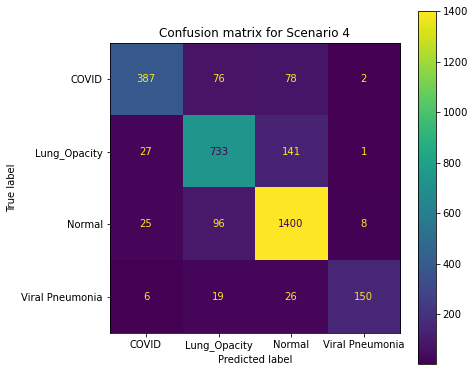

In [461]:
fig, ax = plt.subplots()
fig.set_size_inches(6.5, 6.5)
plt.title(f'Confusion matrix for {chosen["name"]}')
plot_confusion_matrix(classifier, X_test, y_test, display_labels=le.classes_, ax = ax)

In [462]:
y_test.value_counts()

2    1529
1     902
0     543
3     201
dtype: int64

In [463]:
le.classes_

array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], dtype=object)

In [322]:
from shap import Explainer
import shap

In [323]:
explainer = Explainer(classifier)

In [324]:
shap_values = explainer(X_train[:1000])

In [325]:
le.classes_

array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], dtype=object)

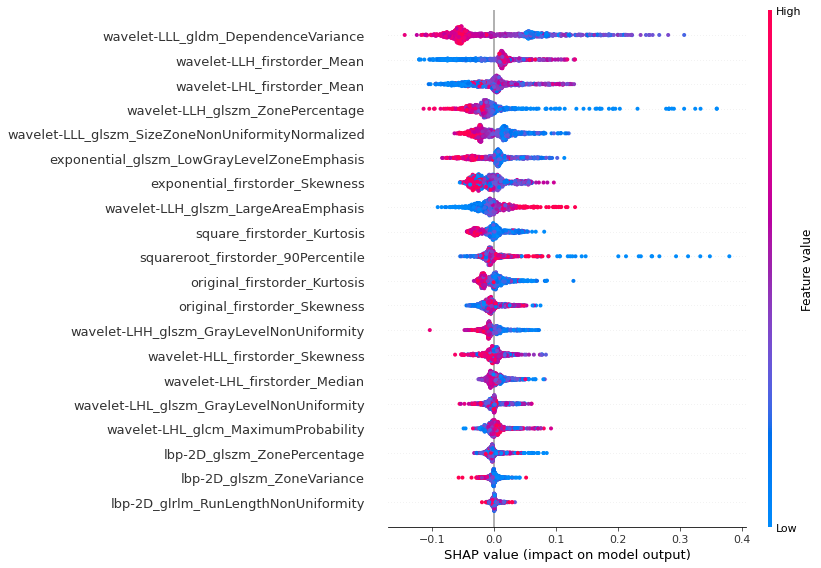

In [326]:
class_num = 0
shap.summary_plot(shap_values.values[:,:,class_num], X_train[:1000], title=f'Shap plot for class {le.classes_[class_num]}')

In [328]:
sizes = [i for i in range(250, len(X_train),250)]
f1s = []
for size in sizes:
    print(size)
    met_part = metadata_train[:size]
    classifier.fit(X_train.loc[met_part.index,:],y_train[met_part.index])
    pred = classifier.predict(X_test)
    f1s.append(f1_score(y_test, pred, average='weighted'))

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750


Text(0.5, 1.0, 'Learning curve for COVID vs Normal, Viral Pneumonia and Lung Opacity scenario')

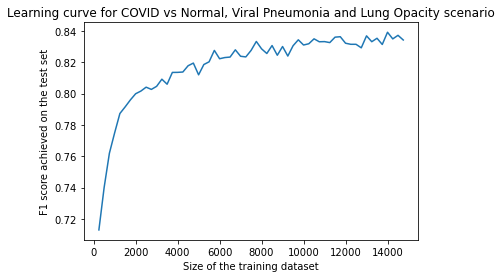

In [334]:
plt.plot(sizes,f1s)
plt.ylabel('F1 score achieved on the test set')
plt.xlabel('Size of the training dataset')
plt.title('Learning curve for COVID vs Normal, Viral Pneumonia and Lung Opacity scenario')

In [330]:
from sklearn.calibration import calibration_curve

In [331]:
pred_proba = classifier.predict_proba(X_test)[:,0]

In [332]:
prob_true, prob_pred = calibration_curve((y_test == 0).astype(int), pred_proba)

Text(0, 0.5, 'Predicted probability of COVID label')

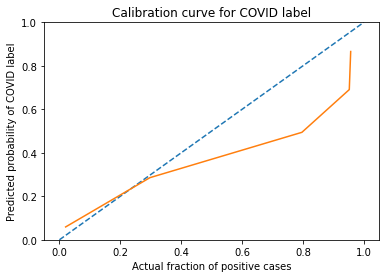

In [333]:
plt.ylim(0,1)
plt.plot([0,1],[0,1], '--')
plt.plot(prob_true, prob_pred)
plt.title('Calibration curve for COVID label')
plt.xlabel('Actual fraction of positive cases')
plt.ylabel('Predicted probability of COVID label')

In [367]:
model_sick_vs_healthy = RandomForestClassifier()
model_sick = RandomForestClassifier()

In [369]:
y_train

id
Normal-5694.png          2
Normal-1419.png          2
Normal-6196.png          2
Normal-1312.png          2
Lung_Opacity-3452.png    1
                        ..
Normal-8205.png          2
Lung_Opacity-3747.png    1
COVID-1723.png           0
Lung_Opacity-1487.png    1
Normal-4469.png          2
Length: 14814, dtype: int32

In [370]:
le.classes_

array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], dtype=object)

In [372]:
y_sick_vs_healthy = y_train.copy()
y_sick_vs_healthy = (y_sick_vs_healthy == 2).astype(int) # 1 is HEALTHY

In [374]:
model_sick_vs_healthy.fit(X_train, y_sick_vs_healthy)

RandomForestClassifier()

In [387]:
model_sick = classifier

In [435]:
sick_v_healthy_pred = model_sick_vs_healthy.predict(X_test)

In [437]:
sick_v_healthy_pred *= 2
sick_v_healthy_pred

array([2, 0, 0, ..., 2, 0, 0])

In [398]:
X_test_sick_predicted = X_test.loc[sick_v_healthy_pred == 0,:]

In [404]:
sick_preds = model_sick.predict(X_test_sick_predicted)

In [403]:
le.classes_

array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], dtype=object)

In [419]:
mapping = {
    0 : 0,
    1 : 1,
    2 : 3
}

In [424]:
sick_preds_mapped = pd.Series(sick_preds).apply(lambda x: mapping[x])

In [438]:
sick_v_healthy_pred[sick_v_healthy_pred == 0] = sick_preds_mapped

In [439]:
f1_score(y_test,sick_v_healthy_pred, average='weighted')

0.6103403926337426

In [434]:
y_test.value_counts()

2    1529
1     902
0     543
3     201
dtype: int64